# Reproduction of figure 5 

In this notebook we describe how to reproduce fig 5 from the paper.




The top left and right pannels of the figure consist in synthesizing $N=50000$ glucose molecules in the branching  and elongation regimes (i.e $\Gamma =0.2$ and $\Gamma =10.0$, respectively).

Input parameters for this simulation are available in the [parameters.json] file. 

Here we only have to play with GS and GBE concentrations, as well as $k_{GS}$ and $k_{GBE}$. For $\Gamma = 0.2$  we set `C0 = {"GS":0.2,"GBE":1,"GP":0.0,"GDE":0.0}` and `k = {"k_GS":1,"k_GBE":1,"k_GP":1,"k_GDE":1}` and for $\Gamma = 10.0$ , we set `C0 = {"GS":1.0,"GBE":0.1,"GP":0.0,"GDE":0.0}` and `k = {"k_GS":1,"k_GBE":1,"k_GP":1,"k_GDE":1}`.
  

In [3]:
import numpy as np
import glycogen_module as gm
import json
import random
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import os
import os.path

random.seed(123)  # add seed for reproducibility

with open("parameters.json", "r") as f:
    parameters = json.load(f)


In [4]:
from algorithm import Gillespie_step


In what follow perform the simulation, starting by initializing `my_granule` and ask to stop the simulation when $N$ glucose units have been incorporated.  

In the paper we generated $N = 50.000$ units, (average time to perform the simulation is about $2-3$ hours). Here we set $N = 1.000$ as a default value to have short computational time.

The following example serves to produce a structure with $\Gamma = 0.2$

In [5]:
my_granule = gm.glycogen_structure(parameters, 2, 1)

parameters['number_max_of_monomer'] = 1000

N = my_granule.number_of_glucose_fixed()

# here set GS = 1.0 and GBE = 0.1 if you want to produce the figure for gamma = 10.0
C0 = {"GS": 0.2, "GBE": 1, "GP": 0.0, "GDE": 0.0}
k = {"k_GS": 1, "k_GBE": 1, "k_GP": 1, "k_GDE": 1}

while N < parameters['number_max_of_monomer']:
    if N % 5000 == 0:
        print('avancement = ', 100*N /
              parameters['number_max_of_monomer'], '%', '   part 1/2')
    reaction, time = Gillespie_step(my_granule, C0)

    if reaction == 'Act_gs()':
        my_granule.Act_gs()
    elif reaction == 'Act_gp()':
        my_granule.Act_gp()
    elif reaction == 'Act_gbe()':
        my_granule.Act_gbe_flexible_model()
    elif reaction == 'Act_gde()':
        my_granule.Act_gde()

    N = my_granule.number_of_glucose_fixed()

# write output
name = 'glycogen_structure_N='+str(N)+'_gamma='+str(C0['GS']/C0['GBE'])+'.json'
my_granule.write_structure(name)


## Reading the outputs:


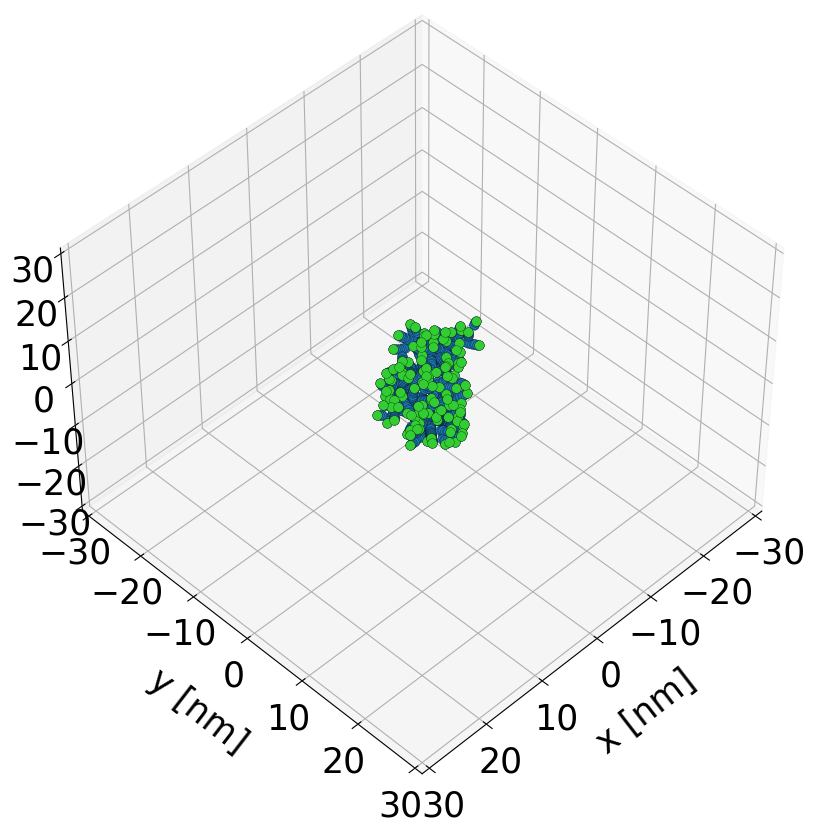

Average degree of polymerisation is:  8.0
Gyration radius of the granule is :  7.0364134674295045 nm


In [6]:
# indicate the pash where the output json file was written
path_file = os.getcwd()+'/'+name

with open(path_file, "r") as f:
    my_granule = json.load(f)

# By default these functions are inside the glycogen_structure class.
# We re-defined here some functions for flexibility


def plot_structure(dict):
    XLIST = []
    YLIST = []
    ZLIST = []
    Xnre = []
    Ynre = []
    Znre = []
    size = 30
    alpha_segment = []
    for chain in dict.values():
        Xnre.append(0.24*chain['glucose_location'][-1][0])
        Ynre.append(0.24*chain['glucose_location'][-1][1])
        Znre.append(0.24*chain['glucose_location'][-1][2])
        for pos in chain['glucose_location']:
            XLIST.append(pos[0])
            YLIST.append(pos[1])
            ZLIST.append(pos[2])

    XLIST, YLIST, ZLIST = 0.24 * \
        np.asarray(XLIST),  0.24*np.asarray(YLIST), 0.24 * np.asarray(ZLIST)
    ax = plt.figure(figsize=(14, 10))
    ax = ax.add_subplot(projection='3d')
    ax.view_init(elev=45, azim=45)
    ax.plot(XLIST, YLIST, ZLIST, 'o', markersize=7, markeredgewidth=0.2,
            markeredgecolor='black', label='glycogen 3d')
    ax.plot(Xnre, Ynre, Znre, 'o', markersize=7, markeredgewidth=0.2,
            color='limegreen', markeredgecolor='black', label='glycogen 3d')
    plt.xlabel('x [nm]', fontsize='25', labelpad=20)
    plt.ylabel('y [nm]', fontsize='25', labelpad=20)
    ax.set_zlabel(r'z [nm]', fontsize='25', rotation=200, labelpad=20)
    ax.set(xlim=(-size, size), ylim=(-size, size), zlim=(-size, size))
    plt.tick_params(labelsize=25)
    plt.savefig('test.elongated.png', pil_kwargs={"quality": 96})
    plt.show()
    ax.legend()


def number_of_glucose_fixed(dict):
    compteur = 0
    for chain in dict.values():
        compteur = compteur + len(chain['glucose_location'])
    return compteur


def radius3D(dict):
    x, y, z = [], [], []
    for chain in dict.values():
        for pos in chain['glucose_location']:
            x.append(pos[0])
            y.append(pos[1])
            z.append(pos[2])
    N = len(x)
    xmean = 1./N*sum(x)
    ymean = 1./N*sum(y)
    zmean = 1./N*sum(z)
    r2 = 1.0/N*sum((x-xmean*np.ones(N))**2+(y-ymean*np.ones(N))
                   ** 2+(z-zmean*np.ones(N))**2)
    return 0.24*r2**0.5, [xmean, ymean, zmean]


plot_structure(my_granule)


def DPmean(dict):
    dplist = []
    for chain in dict.values():
        dplist.append(len(chain['glucose_location']))
    return np.mean(dplist)


print('Average degree of polymerisation is: ', DPmean(my_granule))
rmean, pos = radius3D(my_granule)
print('Gyration radius of the granule is : ', rmean, 'nm')


###  Plotting the chain length distribution as histograms

In [7]:
def DP_distribution(dict):
    histo = []
    for chain in dict.values():
        histo.append(len(chain['glucose_location']))
    return histo


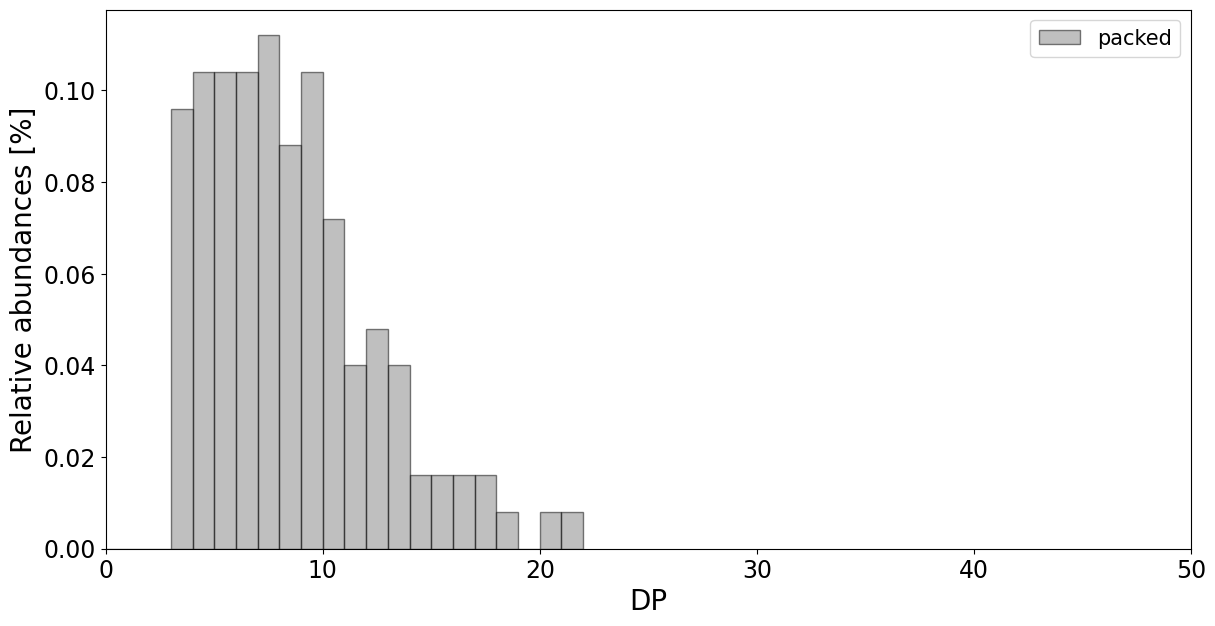

In [8]:
name1 = path_file

with open(name1, "r") as f:
    my_granule1 = json.load(f)


Distrib1 = DP_distribution(my_granule1)
#Distrib2 = DP_distribution(my_granule2)

bins1 = np.linspace(0, max(Distrib1), max(Distrib1)+1)
#bins2 = np.linspace(0,max(Distrib2), max(Distrib2)+1)


plt.figure(figsize=(14, 7))
plt.hist(Distrib1, bins=bins1, color='grey', alpha=0.5,
         edgecolor='black', label='packed', density=1)
#plt.hist(Distrib2, bins= bins2, color = 'black', alpha =0.7, edgecolor = 'black', label = 'elongated', density = 1)
plt.xlabel('DP', fontsize=20)
plt.ylabel('Relative abundances [%]', fontsize=20)
plt.legend(fontsize=15)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.xlim([0, 50])
plt.savefig('fig5c1.png', dpi=350)
plt.show()


# plt.figure(figsize=(14,7))
#plt.hist(Distrib2, bins= bins2, color = 'black', alpha =0.7, edgecolor = 'black', label = 'packed', density = 1)
#plt.tick_params(axis='both', which='major', labelsize=35)
#plt.savefig('fig5c2.png', dpi = 350 )
# plt.show()
